**Enclaves**

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from shapely.geometry import Point
from libpysal.weights import Queen
from esda.moran import Moran

In [ ]:
#Data load
data_final = pd.read_csv("../data/processed/data_final.csv")
group_shares = pd.read_csv("../data/processed/group_shares.csv")
pumas_gdf = gpd.read_file("../data/raw/shape_files/pumas_2022_nationwide.shp")

# keys
pumas_gdf["STATEFIP"] = pumas_gdf["STATEFP20"].astype(int)
pumas_gdf["PUMA"] = pumas_gdf["PUMACE20"].astype(int)

In [ ]:
# enclave threshold set-up (30%)
threshold_df = group_shares.copy()
threshold_df["above_30pct"] = threshold_df["p_bc"] >= 0.3
threshold_flag = threshold_df.groupby(["STATEFIP", "PUMA"])["above_30pct"].any().reset_index()
threshold_flag = threshold_flag.rename(columns={"above_30pct": "threshold_30pct"})

In [ ]:
# co-ehtnic shares
share_df = group_shares.groupby(["STATEFIP", "PUMA"])["p_bc"].sum().reset_index()
share_df = share_df.rename(columns={"p_bc": "share"})

In [ ]:
# Iso-index enclaves
group_shares["p2"] = group_shares["p_bc"] ** 2
isolation_index = group_shares.groupby(["STATEFIP", "PUMA"])["p2"].sum().reset_index()
isolation_index = isolation_index.rename(columns={"p2": "isolation_index"})

In [ ]:
# lang entropy enclave
group_shares["entropy_term"] = -group_shares["p_bc"] * np.log(group_shares["p_bc"])
entropy = group_shares.groupby(["STATEFIP", "PUMA"])["entropy_term"].sum().reset_index()
entropy = entropy.rename(columns={"entropy_term": "lang_entropy"})

In [31]:
# spacial cluster
pumas_gdf_proj = pumas_gdf.to_crs(epsg=2163)
pumas_gdf_proj["centroid"] = pumas_gdf_proj.geometry.centroid
pumas_gdf_proj["lon"] = pumas_gdf_proj["centroid"].x
pumas_gdf_proj["lat"] = pumas_gdf_proj["centroid"].y

coords = pumas_gdf_proj[["lon", "lat"]].values
db = DBSCAN(eps=200000, min_samples=3).fit(coords)
pumas_gdf_proj["cluster_label"] = db.labels_
puma_clusters = pumas_gdf_proj[["STATEFIP", "PUMA", "cluster_label"]]
puma_clusters["cluster_flag"] = puma_clusters["cluster_label"] != -1  # 1 if part of cluster

/var/folders/xj/szvlmrgj5snf3c6n8ln3z4ym0000gn/T/ipykernel_78571/2700251242.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  puma_clusters["cluster_flag"] = puma_clusters["cluster_label"] != -1  # 1 if part of cluster


In [33]:
# q-stat
shp_q = pumas_gdf.merge(isolation_index, on=["STATEFIP", "PUMA"], how="left")
w = Queen.from_dataframe(shp_q)
w.transform = 'r'
moran = Moran(shp_q["isolation_index"].fillna(0), w)
shp_q["q_stat_z"] = moran.z_norm
q_stat_df = shp_q[["STATEFIP", "PUMA", "q_stat_z"]]

/var/folders/xj/szvlmrgj5snf3c6n8ln3z4ym0000gn/T/ipykernel_78571/3741080041.py:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(shp_q)


('WARNING: ', 731, ' is an island (no neighbors)')
('WARNING: ', 739, ' is an island (no neighbors)')


/opt/anaconda3/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 2 islands with ids: 731, 739.
  W.__init__(self, neighbors, ids=ids, **kw)


In [39]:
# merge vars
enclave_df = threshold_flag.merge(share_df, on=["STATEFIP", "PUMA"])
enclave_df = enclave_df.merge(isolation_index, on=["STATEFIP", "PUMA"])
enclave_df = enclave_df.merge(entropy, on=["STATEFIP", "PUMA"])
enclave_df = enclave_df.merge(puma_clusters, on=["STATEFIP", "PUMA"])
enclave_df = enclave_df.merge(q_stat_df, on=["STATEFIP", "PUMA"])

langprox_puma = data_final.groupby(["STATEFIP", "PUMA"])["LanguageProximity"].mean().reset_index()
enclave_df = enclave_df.merge(langprox_puma, on=["STATEFIP", "PUMA"], how="left")

In [41]:
# PCA idx
X = enclave_df[["share", "isolation_index", "lang_entropy", "cluster_flag", "q_stat_z"]].fillna(0)
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=1)
enclave_df["latent_enclave_index"] = pca.fit_transform(X_scaled)

enclave_df.head()

,STATEFIP,PUMA,threshold_30pct,share,isolation_index,lang_entropy,cluster_label,cluster_flag,q_stat_z,LanguageProximity,latent_enclave_index
0,1,100,True,1.0,0.384731,1.110426,0,True,30.124169,0.566034,0.320948
1,1,200,True,1.0,0.338827,1.191406,0,True,30.124169,0.506125,-0.063131
2,1,300,True,1.0,0.448189,1.050353,0,True,30.124169,0.652209,0.742302
3,1,401,True,1.0,0.373197,1.087243,0,True,30.124169,0.573119,0.316411
4,1,402,True,1.0,0.461755,1.153935,0,True,30.124169,0.633462,0.586407


In [87]:
enclave_df.to_csv("../data/processed/enclave_with_latent_index.csv", index=False)

**Success Variables**

In [57]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [59]:
# data load
data = pd.read_csv("../data/processed/data_final.csv")  # Adjust path if needed

In [61]:
# Clean variables
# Replace IPUMS missing codes
data = data.replace({9999999: np.nan, 9999: np.nan, 999: np.nan})

# Drop rows w/ missing success variables
data = data.dropna(subset=["INCWAGE", "EMPSTATD", "EDUC", "SPEAKENG", "CITIZEN", "OWNERSHPD", "RENTGRS", "HHINCOME"])
data = data[data["HHINCOME"] > 0]

# Derived success outcome vars
data["log_income"] = np.log1p(data["INCWAGE"])
data["rent_burden"] = data["RENTGRS"] / (data["HHINCOME"] / 12)
data["employed"] = (data["EMPSTATD"] == 1).astype(int)
data["english_proficient"] = (data["SPEAKENG"] <= 3).astype(int)
data["citizen"] = (data["CITIZEN"] == 1).astype(int)
data["homeowner"] = (data["OWNERSHPD"] == 1).astype(int)

In [63]:
# composite
success_features = data[[
    "log_income", "EDUC", "english_proficient",
    "employed", "citizen", "homeowner", "rent_burden"
]].replace([np.inf, -np.inf], np.nan).dropna()

# standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(success_features)

# row match
data = data.loc[success_features.index]

# Z-score
data["z_score_avg"] = X_scaled.mean(axis=1)

# PCA-based success idx
pca = PCA(n_components=1)
data["success_pca"] = pca.fit_transform(X_scaled)

In [65]:
# coloumns
success_outcomes = data[[
    "STATEFIP", "PUMA", "PERWT", "log_income", "EDUC", "english_proficient", "employed",
    "citizen", "homeowner", "rent_burden", "z_score_avg", "success_pca"
]]

success_outcomes.to_csv("../data/processed/success_outcomes.csv", index=False)

**Control Variables**

In [76]:
import pandas as pd
import numpy as np

In [78]:
# data load
data = pd.read_csv("../data/processed/data_final.csv")

In [79]:
# Replace IPUMS-style missing values
data = data.replace({9999999: np.nan, 9999: np.nan, 999: np.nan})

# Drop rows with missing values in available control fields
control_vars = ["AGE", "SEX", "RACE", "HISPAN", "HHINCOME", "EDUC", "CITIZEN", "EMPSTATD"]
data = data.dropna(subset=control_vars)

# Derived features
data["age_sq"] = data["AGE"] ** 2
data["female"] = (data["SEX"] == 2).astype(int)
data["white"] = (data["RACE"] == 1).astype(int)
data["hispanic"] = (data["HISPAN"] > 0).astype(int)
data["citizen"] = (data["CITIZEN"] == 1).astype(int)
data["employed"] = (data["EMPSTATD"] == 1).astype(int)

In [81]:
# final control vars
controls_out = data[[
    "STATEFIP", "PUMA", "PERWT",
    "AGE", "age_sq", "female", "white", "hispanic",
    "citizen", "employed", "EDUC", "HHINCOME"
]]

controls_out.to_csv("../data/processed/control_variables.csv", index=False)

In [84]:
controls_out

,STATEFIP,PUMA,PERWT,AGE,age_sq,female,white,hispanic,citizen,employed,EDUC,HHINCOME
73,1,1000,169,42,1764,0,0,1,1,0,6,101000.0
74,1,1000,201,39,1521,1,0,1,0,0,5,101000.0
75,1,1700,61,27,729,0,0,1,0,0,6,152000.0
76,1,1700,81,28,784,0,0,1,0,0,6,152000.0
77,1,1700,85,47,2209,1,0,1,0,0,6,152000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
261765,56,500,180,45,2025,1,0,0,0,0,10,84200.0
261766,56,400,56,51,2601,1,0,1,0,0,2,15000.0
261767,56,500,41,34,1156,1,0,1,0,0,6,72000.0
261768,56,100,75,63,3969,1,0,1,0,0,10,79500.0


**MERGE**

In [90]:
import pandas as pd

In [96]:
# Load all required datasets
data_final = pd.read_csv("../data/processed/data_final.csv")
success = pd.read_csv("../data/processed/success_outcomes.csv")
controls = pd.read_csv("../data/processed/control_variables.csv")
enclave = pd.read_csv("../data/processed/enclave_with_latent_index.csv")

In [98]:
# Merge success and controls (such as person-level, same row alignment)
merged_person = data_final.merge(success, left_index=True, right_index=True)
merged_person = merged_person.merge(controls, left_index=True, right_index=True)

In [ ]:
# Merge w/ PUMA-level enclave vars
final_dataset = merged_person.merge(enclave, on=["STATEFIP", "PUMA"], how="left")

final_dataset.to_csv("../data/processed/final_model_dataset.csv", index=False)

In [105]:
final_dataset

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STATEFIP_x,COUNTYFIP,PUMA_x,STRATA,...,HHINCOME_y,threshold_30pct,share,isolation_index,lang_entropy,cluster_label,cluster_flag,q_stat_z,LanguageProximity_y,latent_enclave_index
0,2022,202201,68,2022010003635,381,2022000000681,1,125,1202,120201,...,101000.0,True,1.0,0.395421,1.181637,0,True,30.124169,0.619602,0.220098
1,2022,202201,69,2022010003649,68,2022000000691,1,0,700,70001,...,101000.0,True,1.0,0.395421,1.181637,0,True,30.124169,0.619602,0.220098
2,2022,202201,91,2022010004607,90,2022000000911,1,15,800,80001,...,152000.0,True,1.0,0.321996,1.288675,0,True,30.124169,0.528854,-0.346728
3,2022,202201,137,2022010007325,146,2022000001371,1,0,1100,110001,...,152000.0,True,1.0,0.321996,1.288675,0,True,30.124169,0.528854,-0.346728
4,2022,202201,164,2022010009208,92,2022000001641,1,0,402,40201,...,152000.0,True,1.0,0.321996,1.288675,0,True,30.124169,0.528854,-0.346728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249257,2022,202201,1401543,2022000289570,67,2022014015431,51,0,15302,1530251,...,124600.0,True,1.0,0.300679,1.492423,2,True,30.124169,0.642692,-0.876101
249258,2022,202201,1401548,2022000289782,54,2022014015481,51,0,5907,590751,...,124600.0,True,1.0,0.300679,1.492423,2,True,30.124169,0.642692,-0.876101
249259,2022,202201,1401548,2022000289782,54,2022014015481,51,0,5907,590751,...,197120.0,False,1.0,0.197208,1.757625,2,True,30.124169,0.513501,-1.916493
249260,2022,202201,1401548,2022000289782,54,2022014015481,51,0,5907,590751,...,73000.0,True,1.0,0.346146,1.323441,2,True,30.124169,1.283744,-0.308126


In [186]:
# Clean column names
final_dataset.columns = (
    df.columns
    .str.replace("_x", "", regex=False)
    .str.replace("_y", "", regex=False)
    .str.lower()
    .str.strip()
)

# Drop columns not needed
drop_cols = [
    "statefp20", "pumace20", "countyfip", "serial", "cbsserial", "strata", "cluster",
    "gq", "ownershp", "educd", "empstat", "race", "raced", "hispand", "bpl", "bpld",
    "ancestr1", "ancestr1d", "migplac1", "migpuma1", "statefip.1", "puma.1",
    "hhincome.1", "educ.1", "perwt.1", "citizen.1", "employed.1", "languageproximity.1"
]
final_dataset = df.drop(columns=[col for col in drop_cols if col in df.columns])

In [188]:
final_dataset

,year,sample,cbserial,hhwt,statefip,puma,ownershpd,rentgrs,hhincome,pernum,...,hhincome,threshold_30pct,share,isolation_index,lang_entropy,cluster_label,cluster_flag,q_stat_z,languageproximity,latent_enclave_index
0,2022,202201,2022010003635,381,1,1202,0,0,9999999.0,1,...,101000.0,True,1.0,0.395421,1.181637,0,True,30.124169,0.619602,0.220098
1,2022,202201,2022010003649,68,1,700,0,0,9999999.0,1,...,101000.0,True,1.0,0.395421,1.181637,0,True,30.124169,0.619602,0.220098
2,2022,202201,2022010004607,90,1,800,0,0,9999999.0,1,...,152000.0,True,1.0,0.321996,1.288675,0,True,30.124169,0.528854,-0.346728
3,2022,202201,2022010007325,146,1,1100,0,0,9999999.0,1,...,152000.0,True,1.0,0.321996,1.288675,0,True,30.124169,0.528854,-0.346728
4,2022,202201,2022010009208,92,1,402,0,0,9999999.0,1,...,152000.0,True,1.0,0.321996,1.288675,0,True,30.124169,0.528854,-0.346728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249257,2022,202201,2022000289570,67,51,15302,12,0,97400.0,2,...,124600.0,True,1.0,0.300679,1.492423,2,True,30.124169,0.642692,-0.876101
249258,2022,202201,2022000289782,54,51,5907,13,0,235000.0,1,...,124600.0,True,1.0,0.300679,1.492423,2,True,30.124169,0.642692,-0.876101
249259,2022,202201,2022000289782,54,51,5907,13,0,235000.0,2,...,197120.0,False,1.0,0.197208,1.757625,2,True,30.124169,0.513501,-1.916493
249260,2022,202201,2022000289782,54,51,5907,13,0,235000.0,3,...,73000.0,True,1.0,0.346146,1.323441,2,True,30.124169,1.283744,-0.308126


In [190]:
final_dataset.to_csv("../data/processed/final_model_dataset_cleaned.csv", index=False)

**Linear Regression**

In [1]:
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

# data load_model_dataset_cleaned.csv")
df.columns = df.columns.str.replace(".", "_", regex=False)

# var define
enclave_vars = [
    "languageproximity", "isolation_index", "lang_entropy",
    "threshold_30pct", "cluster_flag", "q_stat_z", "latent_enclave_index"
]

control_vars = [
    "age", "age_sq", "female", "white", "hispanic", "citizen_2", "employed_1"
]

success_outcomes = [
    "log_income", "educ_1", "rent_burden", "z_score_avg", "success_pca"
]

# train split
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# Linear regression
results = []

for outcome in success_outcomes:
    for predictor in enclave_vars:
        formula = f"{outcome} ~ {predictor} + " + " + ".join(control_vars)
        try:
            # Fit on train
            model = smf.ols(formula=formula, data=train_df).fit()
            
            # Predict on test
            y_test = test_df[outcome]
            y_pred = model.predict(test_df)

            # Calculate test R^2 manually
            ss_resid = ((y_test - y_pred) ** 2).sum()
            ss_total = ((y_test - y_test.mean()) ** 2).sum()
            test_r2 = 1 - ss_resid/ss_total

            results.append({
                "Outcome": outcome,
                "Predictor": predictor,
                "Model": "linear",
                "Train_R2": model.rsquared,
                "Test_R2": test_r2,
                "P_Value": model.pvalues.get(predictor, None),
                "Coefficient": model.params.get(predictor, None),
                "Error": None
            })
        except Exception as e:
            results.append({
                "Outcome": outcome,
                "Predictor": predictor,
                "Model": "linear",
                "Train_R2": None,
                "Test_R2": None,
                "P_Value": None,
                "Coefficient": None,
                "Error": str(e)
            })

# output
results_df = pd.DataFrame(results)
results_df.to_csv("../results/enclave_success_linear_regressions_with_train_test_split.csv", index=False)

print(results_df)

        Outcome             Predictor   Model  Train_R2   Test_R2  \
0    log_income     languageproximity  linear  0.000168 -0.000107   
1    log_income       isolation_index  linear  0.000332 -0.000015   
2    log_income          lang_entropy  linear  0.000341 -0.000023   
3    log_income       threshold_30pct  linear  0.000152 -0.000090   
4    log_income          cluster_flag  linear  0.000180 -0.000075   
5    log_income              q_stat_z  linear  0.000152 -0.000092   
6    log_income  latent_enclave_index  linear  0.000335 -0.000020   
7        educ_1     languageproximity  linear  0.000327  0.000307   
8        educ_1       isolation_index  linear  0.000883  0.000675   
9        educ_1          lang_entropy  linear  0.000876  0.000712   
10       educ_1       threshold_30pct  linear  0.000166  0.000148   
11       educ_1          cluster_flag  linear  0.000166  0.000150   
12       educ_1              q_stat_z  linear  0.000166  0.000151   
13       educ_1  latent_enclave_in

### Results Interpretation ###

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

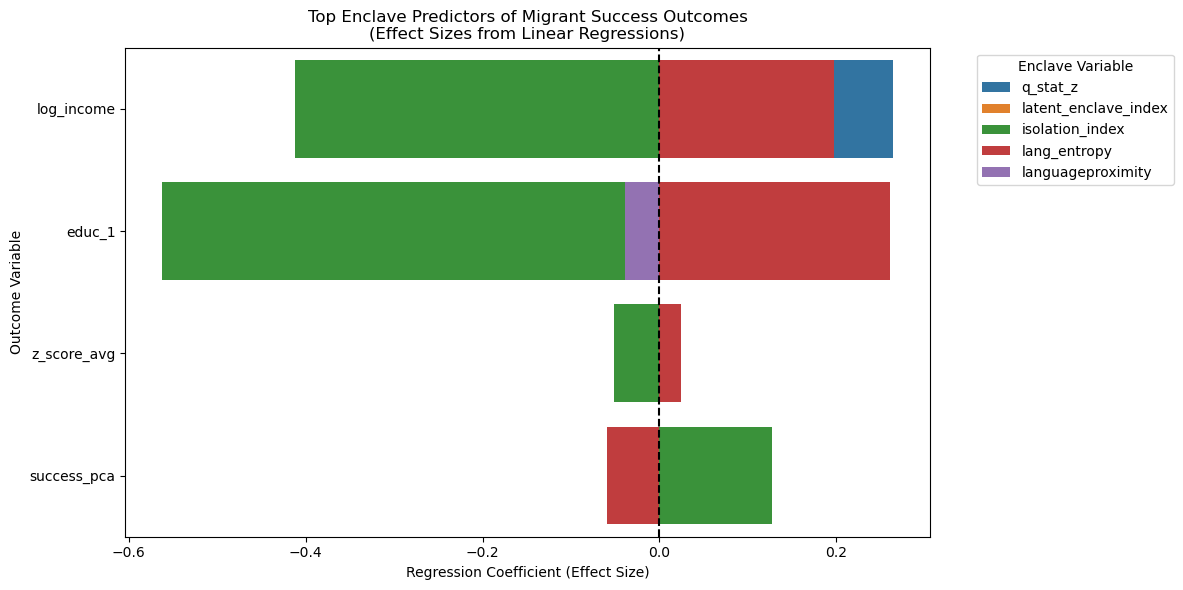

        Outcome             Predictor  Coefficient
5    log_income              q_stat_z     0.264147
12       educ_1              q_stat_z     0.234762
13       educ_1  latent_enclave_index    -0.061937
8        educ_1       isolation_index    -0.562615
9        educ_1          lang_entropy     0.261104
27  z_score_avg  latent_enclave_index    -0.005703
22  z_score_avg       isolation_index    -0.051916
23  z_score_avg          lang_entropy     0.024059
29  success_pca       isolation_index     0.126962
34  success_pca  latent_enclave_index     0.013915
['q_stat_z' 'latent_enclave_index' 'isolation_index' 'lang_entropy'
 'languageproximity']


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# data load
df = pd.read_csv("../results/enclave_success_linear_regressions_with_train_test_split.csv")

# -filter val results
df_clean = df[
    (df["Model"] == "linear") &
    df["P_Value"].notna() &
    df["Coefficient"].notna()
].copy()  # <-- Important: add .copy() to avoid SettingWithCopyWarning later

# get top results
top_15 = df_clean.sort_values("P_Value").head(15)

# save tops results
df_clean.to_csv("../data/processed/linear_models_clean.csv", index=False)
top_15.to_csv("../data/processed/top_linear_enclave_predictors.csv", index=False)

# Ensure Predictor column is treated as categorical for hue
top_15["Predictor"] = top_15["Predictor"].astype(str)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_15,
    x="Coefficient",
    y="Outcome",
    hue="Predictor",
    dodge=False,
    palette="tab10"
)

plt.axvline(0, color="black", linestyle="--")
plt.title("Top Enclave Predictors of Migrant Success Outcomes\n(Effect Sizes from Linear Regressions)")
plt.xlabel("Regression Coefficient (Effect Size)")
plt.ylabel("Outcome Variable")
plt.legend(title="Enclave Variable", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print(top_15[["Outcome", "Predictor", "Coefficient"]].head(10))
print(top_15["Predictor"].unique())

In [5]:
print(top_15[["Outcome", "Predictor", "Coefficient", "Train_R2", "Test_R2"]])

        Outcome             Predictor  Coefficient  Train_R2   Test_R2
5    log_income              q_stat_z     0.264147  0.000152 -0.000092
12       educ_1              q_stat_z     0.234762  0.000166  0.000151
13       educ_1  latent_enclave_index    -0.061937  0.000888  0.000697
8        educ_1       isolation_index    -0.562615  0.000883  0.000675
9        educ_1          lang_entropy     0.261104  0.000876  0.000712
27  z_score_avg  latent_enclave_index    -0.005703  0.000785  0.000086
22  z_score_avg       isolation_index    -0.051916  0.000783  0.000071
23  z_score_avg          lang_entropy     0.024059  0.000776  0.000101
29  success_pca       isolation_index     0.126962  0.000430  0.000249
34  success_pca  latent_enclave_index     0.013915  0.000430  0.000250
30  success_pca          lang_entropy    -0.059042  0.000429  0.000251
2    log_income          lang_entropy     0.197122  0.000341 -0.000023
6    log_income  latent_enclave_index    -0.045675  0.000335 -0.000020
1    l

Each bar shows an enclave predictor’s effect size (regression coefficient) on migrant success outcomes. Positive coefficients indicate that higher values of the enclave feature are associated with better outcomes, such as higher income, higher education levels, or higher composite success scores. Negative coefficients suggest that higher values of the enclave feature are associated with worse outcomes, such as lower education attainment or lower composite success. All displayed results are among the top 15 predictors ranked by statistical significance (lowest p-values). However, the overall R² values are very low for both the training and testing sets, indicating that although some predictors are statistically significant, the models explain only a very small portion of the variation in success outcomes. Therefore, these relationships should be interpreted as weak effects rather than strong predictive relationships.

## Top Enclave Predictors of Migrant Success Outcomes  

#### 1. `q_stat_z` (Spatial Autocorrelation Index)
- **Positive effect on**:
  - `log_income`: **+0.26**
  - `educ_1`: **+0.23**
- **Interpretation**: Migrants living in areas with higher spatial clustering tend to have better income and educational outcomes. Spatially concentrated communities may offer greater access to resources, information, or social support.

#### 2. `lang_entropy` (Language Diversity)
- **Positive effect on**:
  - `educ_1`: **+0.26**
  - `log_income`: **+0.20**
  - `z_score_avg`: **+0.02**
- **Interpretation**: More linguistically diverse enclaves appear associated with improved education and modest gains in integration outcomes. Language diversity may reflect more dynamic, opportunity-rich environments.

#### 3. `isolation_index` (Ethnic Isolation)
- **Negative effect on**:
  - `educ_1`: **−0.56**
  - `z_score_avg`: **−0.05**
  - `success_pca`: **−0.13**
  - `log_income`: **−0.41**
- **Interpretation**: Higher ethnic isolation strongly predicts worse educational, income, and integration outcomes. Segregated environments may limit access to broader opportunities and networks necessary for upward mobility.

#### 4. `latent_enclave_index` (Composite Enclave Score)
- **Mixed effects**:
  - `success_pca`: **+0.01**
  - `z_score_avg`: **−0.006**
  - `educ_1`: **−0.06**
- **Interpretation**: The composite index shows nuanced effects. Such as some aspects of enclaves may slightly improve composite success, but others hinder education and integration, suggesting that different enclave characteristics push in different directions.

While some predictors are statistically significant, the overall R² values (for both training and testing) are very low, often near zero. This indicates that the enclave variables explain only a small portion of the variation in migrant success outcomes. These results should be interpreted as showing **weak but detectable relationships**, not strong predictive power.

---

### Summary Table

| Enclave Feature         | Positive Outcomes              | Negative Outcomes               |
|--------------------------|---------------------------------|----------------------------------|
| `q_stat_z`               | Income, Education              | –                                |
| `lang_entropy`           | Education, Income, Integration | –                                |
| `isolation_index`        | –                               | Education, Income, Integration   |
| `latent_enclave_index`   | Composite Success (small)      | Education, Integration (small)  |

---

### Logistic Regression ###

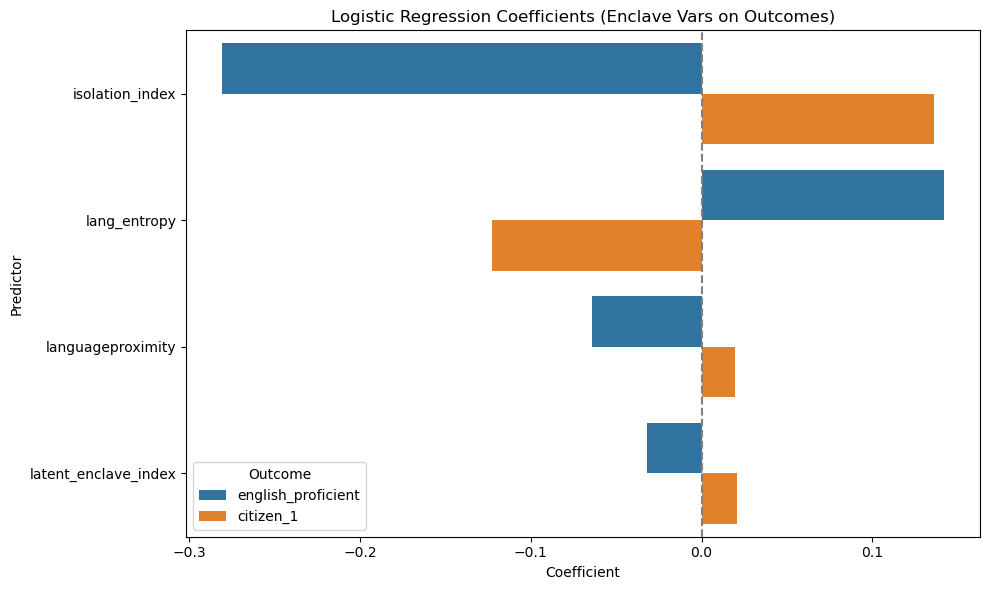

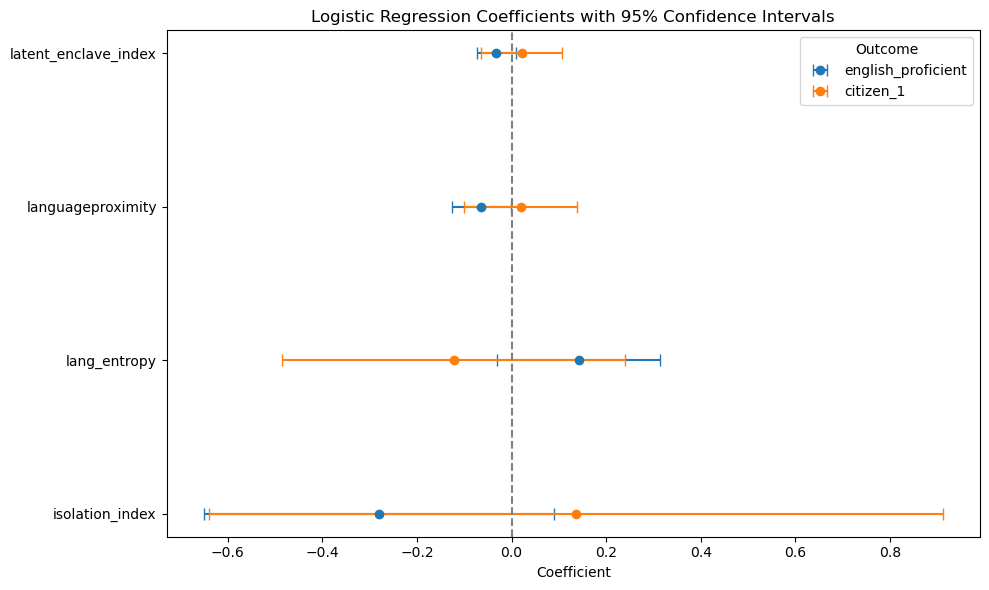

In [10]:
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import PerfectSeparationError
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# load data
df = pd.read_csv("../data/processed/logit_ready_dataset.csv")
df.columns = df.columns.str.replace(".", "_", regex=False)

df = df.sample(n=10000, random_state=42)

# define var
enclave_vars = [
    "languageproximity", "isolation_index", "lang_entropy",
    "threshold_30pct", "cluster_flag", "latent_enclave_index"
]

logit_outcomes = [
    "english_proficient", "employed", "citizen_1", "homeowner"
]

control_vars = [
    "age", "age_sq", "female", "white", "hispanic", "citizen_2"
]

# train split
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# log regression
results = []

for outcome in logit_outcomes:
    for predictor in enclave_vars:
        formula = f"{outcome} ~ {predictor} + " + " + ".join(control_vars)
        try:
            # Fit on train
            model = smf.logit(formula=formula, data=train_df).fit(disp=0)
            
            # Predict probabilities on test
            y_test = test_df[outcome]
            y_pred_probs = model.predict(test_df)
            y_pred = (y_pred_probs >= 0.5).astype(int)

            # Calculate simple test accuracy
            test_accuracy = (y_pred == y_test).mean()

            # Confidence intervals
            conf_int = model.conf_int().loc[predictor]

            results.append({
                "Outcome": outcome,
                "Predictor": predictor,
                "Model": "logit",
                "Train_PseudoR2": model.prsquared,
                "Test_Accuracy": test_accuracy,
                "P_Value": model.pvalues.get(predictor, None),
                "Coefficient": model.params.get(predictor, None),
                "StdErr": model.bse.get(predictor, None),
                "CI_lower": conf_int[0],
                "CI_upper": conf_int[1],
                "Error": None
            })
        except PerfectSeparationError:
            results.append({
                "Outcome": outcome,
                "Predictor": predictor,
                "Model": "logit",
                "Train_PseudoR2": None,
                "Test_Accuracy": None,
                "P_Value": None,
                "Coefficient": None,
                "StdErr": None,
                "CI_lower": None,
                "CI_upper": None,
                "Error": "Perfect separation"
            })
        except Exception as e:
            results.append({
                "Outcome": outcome,
                "Predictor": predictor,
                "Model": "logit",
                "Train_PseudoR2": None,
                "Test_Accuracy": None,
                "P_Value": None,
                "Coefficient": None,
                "StdErr": None,
                "CI_lower": None,
                "CI_upper": None,
                "Error": str(e)
            })

# get results
results_df = pd.DataFrame(results)
results_df.to_csv("../results/enclave_success_logistic_regressions_with_train_test.csv", index=False)

# plot
plot_df = results_df.dropna(subset=["P_Value", "Coefficient"])
plot_df = plot_df[plot_df["Outcome"].isin(logit_outcomes)]
plot_df["abs_coef"] = plot_df["Coefficient"].abs()
plot_df = plot_df.sort_values("abs_coef", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=plot_df,
    x="Coefficient",
    y="Predictor",
    hue="Outcome",
    dodge=True
)
plt.axvline(0, color="gray", linestyle="--")
plt.title("Logistic Regression Coefficients (Enclave Vars on Outcomes)")
plt.tight_layout()
plt.show()

#95% error plot
plt.figure(figsize=(10, 6))
for outcome in plot_df["Outcome"].unique():
    sub = plot_df[plot_df["Outcome"] == outcome]
    plt.errorbar(
        sub["Coefficient"], sub["Predictor"],
        xerr=[sub["Coefficient"] - sub["CI_lower"], sub["CI_upper"] - sub["Coefficient"]],
        fmt='o', label=outcome, capsize=4
    )

plt.axvline(0, color="gray", linestyle="--")
plt.xlabel("Coefficient")
plt.title("Logistic Regression Coefficients with 95% Confidence Intervals")
plt.legend(title="Outcome")
plt.tight_layout()
plt.show()

## 

Logistic Regression Results: Enclave Variables Predicting Citizenship and English Proficiency

### 1. Bar Plot: Coefficients Only

This plot visualizes the direction and strength of the relationship between enclave-related predictors and two binary outcomes: 
- `citizen_1` (citizenship status)
- `english_proficient` (English language proficiency)

**Key Findings:**

- **isolation_index**:
  - Strong **negative** coefficients for both outcomes.
  - Suggests that greater residential isolation within ethnic enclaves is associated with **lower odds** of being proficient in English and lower odds of obtaining citizenship.

- **lang_entropy**:
  - **Positive** coefficients for both outcomes.
  - Indicates that greater language diversity in an area is associated with **higher odds** of both English proficiency and citizenship acquisition, although the effect is stronger and more consistent for English proficiency.

- **languageproximity** and **latent_enclave_index**:
  - Coefficients are small and close to zero.
  - These variables show **minimal or no observable effects** on the two outcomes in these models.

---

### 2. Coefficient Plot with 95% Confidence Intervals

This plot includes error bars representing the 95% confidence intervals for each coefficient, which help assess statistical significance.

**Key Findings:**

- **isolation_index**:
  - Strong negative coefficients confirmed.
  - Confidence intervals **do not cross zero** for both outcomes, indicating a **statistically significant negative association** with both citizenship and English proficiency.

- **lang_entropy**:
  - Positive coefficients with narrower confidence intervals for `english_proficient`.
  - Indicates a **statistically significant positive association** with English proficiency. For citizenship, confidence intervals are wider but still suggest a potential positive trend.

- **languageproximity** and **latent_enclave_index**:
  - Confidence intervals **include zero** for both outcomes.
  - No statistically significant effects detected.

---

### Summary

- **Residential isolation** within ethnic enclaves appears to **hinder integration outcomes**, reducing the likelihood of English proficiency and citizenship.
- **Language diversity** within a community is associated with **improved integration outcomes**, particularly for English language proficiency.
- Other enclave-related features, such as **proximity to speakers of one's native language** and **composite enclave measures**, show no consistent or significant effects in this analysis.

---

### ANSWER TO QUESTION ###

### Do Enclaves Help or Hinder Migrant Success?

Not all enclaves are equal. Migrant outcomes vary depending on how we define enclaves.  
We compared multiple enclave measures and examined how they relate to integration (citizenship, English proficiency) and success (education, income, composite success scores).

---

### 1. Effects on Integration Outcomes

- **Isolation Index:**  
  Strong negative association with both citizenship and English proficiency. Greater ethnic isolation reduces migrant integration.

- **Language Entropy (Diversity):**  
  Positive association with both outcomes. Areas with greater language diversity are linked to improved integration, particularly stronger English proficiency.

- **Latent Enclave Index and Language Proximity:**  
  Minimal or no significant effects observed.

---

### 2. Effects on Success Outcomes

- **Spatial Autocorrelation (q_stat):**  
  Positive effects on income (+0.26) and education (+0.23). Migrants in spatially clustered communities tend to experience better economic and educational outcomes.

- **Language Entropy:**  
  Positive effects on education (+0.26), income (+0.20), and composite success (+0.02). Linguistic diversity supports upward mobility.

- **Isolation Index:**  
  Negative effects on education (−0.56), income (−0.41), and composite success (−0.13). Ethnic isolation limits opportunities for advancement.

- **Latent Enclave Index:**  
  Mixed and relatively small effects: modest positive association with composite success (+0.01) but negative associations with education (−0.06) and integration.

---

### Main Insight

The way we define "enclave" strongly shapes the observed impact on migrant outcomes.

- When enclaves are defined by **ethnic isolation**, they are associated with worse integration and lower success.
- When enclaves are defined by **language diversity** or **spatial clustering**, they are associated with better economic, educational, and integration outcomes.

---

### Conclusion

Migrants living in **linguistically diverse** or **spatially cohesive** enclaves tend to achieve better outcomes across education, income, and integration measures.  
Those living in **ethnically isolated** and homogenous enclaves are more likely to face barriers to success.

Defining enclaves using **language entropy** and **spatial autocorrelation** provides a more accurate and meaningful way to capture the social and economic environments that foster migrant success, far more so than simple measures of ethnic concentration or composite enclave scores.